
# Part 3: Model Evaluation for Imbalanced Data

In this notebook we evaluate the performance of several churn prediction models using metrics appropriate for imbalanced data. We also examine the business impact of different types of errors and explore threshold optimization to improve retention strategies.



## Objectives

- Compare model performance using precision, recall, F1‑score, ROC AUC, and Precision–Recall AUC.
- Generate confusion matrices for each model to understand error types (false positives and false negatives).
- Perform threshold optimization to maximize the F1‑score and assess the trade‑offs between precision and recall.
- Conduct a cost‑sensitive analysis based on estimated business costs of false positives and false negatives.
- Assess statistical significance of performance differences and derive business insights.

The dataset used here has missing values already handled (`ChurnData_Missing_Handled.csv`).


In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, precision_recall_curve)
from scipy import stats

warnings.filterwarnings('ignore')


In [2]:

# Load preprocessed dataset (missing values already handled)
df = pd.read_csv('Data/Processed/ChurnData_Missing_Handled.csv')

# Preview dataset
print(df.shape)
df.head()


(7032, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



### Feature Engineering

We reproduce the same feature engineering steps from Part 2 to ensure consistency across models. These include:

- **`tenure_group`** – Categorizes `tenure` into `New` (≤12 months), `Established` (13–48 months), or `Loyal` (>48 months).
- **`service_count`** – Counts the number of subscribed optional services (`Yes` across various service features).
- **`avg_charge_per_service`** – Computes the average monthly charge per subscribed service.
- **`pay_reliable`** – Flags whether the payment method is automatic (`1` if `Bank transfer (automatic)` or `Credit card (automatic)`, `0` otherwise).

These engineered features capture customer lifecycle, engagement, and payment reliability—factors correlated with churn.


In [3]:

# Create engineered features
bins = [0, 12, 48, np.inf]
labels = ['New', 'Established', 'Loyal']
df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True, include_lowest=True)

service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

def count_services(row):
    count = 0
    for col in service_cols:
        if row[col] == 'Yes':
            count += 1
    return count

# Compute service_count and avg_charge_per_service
df['service_count'] = df.apply(count_services, axis=1)
df['avg_charge_per_service'] = df['MonthlyCharges'] / df['service_count'].replace(0, np.nan)
df['avg_charge_per_service'].fillna(0, inplace=True)

# Payment reliability indicator
automatic_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
df['pay_reliable'] = df['PaymentMethod'].apply(lambda x: 1 if x in automatic_methods else 0)

# Define target and features
y = df['Churn'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['customerID', 'Churn'])

# Identify numeric and categorical columns
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges',
                   'service_count', 'avg_charge_per_service', 'pay_reliable']
categorical_features = [col for col in X.columns if col not in numeric_features]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)


Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'service_count', 'avg_charge_per_service', 'pay_reliable']
Categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']


In [4]:

# Preprocessor: scale numeric and one-hot encode categorical
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [5]:

# Cross-validation and scoring definitions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

# Helper function to summarize CV results
def summarize_cv(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}


In [6]:

# Logistic Regression pipeline
log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))])

# Decision Tree pipeline
dec_tree = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(max_depth=6, class_weight='balanced'))])

# Evaluate baseline models
log_cv = cross_validate(log_reg, X, y, cv=cv, scoring=scoring, n_jobs=-1)
dt_cv = cross_validate(dec_tree, X, y, cv=cv, scoring=scoring, n_jobs=-1)

baseline_results = pd.DataFrame({
    'LogisticRegression': summarize_cv(log_cv),
    'DecisionTree': summarize_cv(dt_cv)
}).T

baseline_results


,precision,recall,f1,roc_auc,pr_auc
LogisticRegression,0.514535,0.794019,0.624358,0.845559,0.657839
DecisionTree,0.494997,0.798284,0.610951,0.825607,0.596880


In [7]:

# Random Forest pipeline
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))])

rf_param_grid = {
    'classifier__n_estimators': [200, 400],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                       scoring='f1', n_jobs=-1, verbose=0)

rf_grid.fit(X, y)
rf_best = rf_grid.best_estimator_

rf_cv = cross_validate(rf_best, X, y, cv=cv, scoring=scoring, n_jobs=-1)
rf_results = summarize_cv(rf_cv)

rf_results


{'precision': np.float64(0.5489673275904784),
 'recall': np.float64(0.7212498745537699),
 'f1': np.float64(0.6233484628108974),
 'roc_auc': np.float64(0.8427943890247438),
 'pr_auc': np.float64(0.6591575485808597)}

In [8]:

# XGBoost pipeline
xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                                                     scale_pos_weight=(y==0).sum()/(y==1).sum(),
                                                     use_label_encoder=False, random_state=42))])

xgb_param_grid = {
    'classifier__n_estimators': [200, 400],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.05],
    'classifier__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_param_grid, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                       scoring='f1', n_jobs=-1, verbose=0)

xgb_grid.fit(X, y)
xgb_best = xgb_grid.best_estimator_

xgb_cv = cross_validate(xgb_best, X, y, cv=cv, scoring=scoring, n_jobs=-1)
xgb_results = summarize_cv(xgb_cv)

xgb_results


{'precision': np.float64(0.5181958439293763),
 'recall': np.float64(0.8041820188957864),
 'f1': np.float64(0.630222863689594),
 'roc_auc': np.float64(0.8473717691717386),
 'pr_auc': np.float64(0.6681640449471319)}

In [9]:

# Identify categorical indices for CatBoost
cat_features_idx = [X.columns.get_loc(c) for c in categorical_features]

# CatBoost model
tuned_cat = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    iterations=300,
    loss_function='Logloss',
    eval_metric='AUC',
    random_state=42,
    verbose=False
)

# Evaluate CatBoost via cross-validation
cat_metrics = {metric: [] for metric in scoring}
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    tuned_cat.fit(X_train, y_train, cat_features=cat_features_idx)
    preds = tuned_cat.predict(X_test)
    probas = tuned_cat.predict_proba(X_test)[:,1]
    cat_metrics['precision'].append(precision_score(y_test, preds))
    cat_metrics['recall'].append(recall_score(y_test, preds))
    cat_metrics['f1'].append(f1_score(y_test, preds))
    cat_metrics['roc_auc'].append(roc_auc_score(y_test, probas))
    cat_metrics['pr_auc'].append(average_precision_score(y_test, probas))

cat_results = {k: np.mean(v) for k,v in cat_metrics.items()}
cat_results


{'precision': np.float64(0.6753970911116168),
 'recall': np.float64(0.5318346690370029),
 'f1': np.float64(0.5950088355423242),
 'roc_auc': np.float64(0.8476057567930401),
 'pr_auc': np.float64(0.6683802023484634)}


### Model Performance Summary

We compile the evaluation results from all models into a single table sorted by F1‑score. Each metric is the mean across the 5 cross‑validation folds.


In [10]:

# Consolidate results
evaluation_df = pd.DataFrame({
    'LogisticRegression': baseline_results.loc['LogisticRegression'],
    'DecisionTree': baseline_results.loc['DecisionTree'],
    'RandomForest': rf_results,
    'XGBoost': xgb_results,
    'CatBoost': cat_results
}).T

evaluation_df = evaluation_df.sort_values('f1', ascending=False)

evaluation_df


,precision,recall,f1,roc_auc,pr_auc
XGBoost,0.518196,0.804182,0.630223,0.847372,0.668164
LogisticRegression,0.514535,0.794019,0.624358,0.845559,0.657839
RandomForest,0.548967,0.721250,0.623348,0.842794,0.659158
DecisionTree,0.494997,0.798284,0.610951,0.825607,0.596880
CatBoost,0.675397,0.531835,0.595009,0.847606,0.668380



### Confusion Matrices

The confusion matrix shows the counts of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP) for each model. Understanding these counts is essential for assessing business impact.


In [11]:

# Function to compute confusion matrices for scikit-learn models
def get_confusion_matrix(model, X, y, cv):
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    return confusion_matrix(y, y_pred)

models_dict = {
    'LogisticRegression': log_reg,
    'DecisionTree': dec_tree,
    'RandomForest': rf_best,
    'XGBoost': xgb_best
}
conf_matrices = {name: get_confusion_matrix(model, X, y, cv) for name, model in models_dict.items()}

# CatBoost confusion matrix (manual cross-validation)
cat_preds = np.zeros_like(y)
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    tuned_cat.fit(X_train, y_train, cat_features=cat_features_idx)
    cat_preds[test_idx] = tuned_cat.predict(X_test)
conf_matrices['CatBoost'] = confusion_matrix(y, cat_preds)

conf_matrices


{'LogisticRegression': array([[3762, 1401],
        [ 385, 1484]]),
 'DecisionTree': array([[3642, 1521],
        [ 377, 1492]]),
 'RandomForest': array([[4055, 1108],
        [ 521, 1348]]),
 'XGBoost': array([[3765, 1398],
        [ 366, 1503]]),
 'CatBoost': array([[4685,  478],
        [ 875,  994]])}

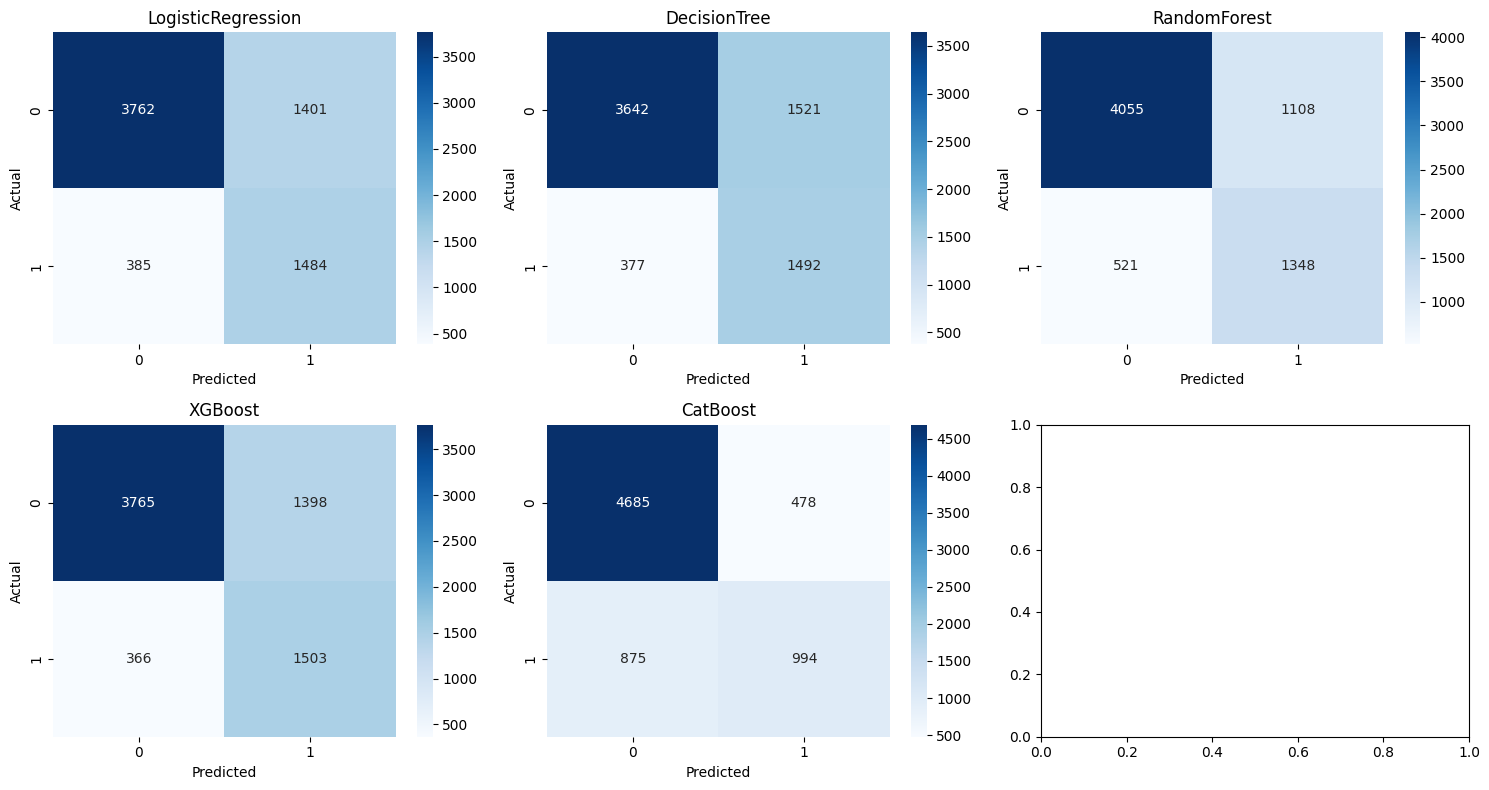

In [12]:

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, (name, cm) in enumerate(conf_matrices.items()):
    ax = axes[idx//3][idx%3]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()



## Threshold Optimization

Instead of using a default probability threshold of 0.5, we search for the threshold that maximizes the F1‑score for the best performing model (highest F1 in the summary table). This optimizes the balance between precision and recall.


In [13]:

# Identify best model (highest F1)
best_model_name = evaluation_df.index[0]
print('Best model based on F1:', best_model_name)

# Map the best model object
model_mapping = {
    'LogisticRegression': log_reg,
    'DecisionTree': dec_tree,
    'RandomForest': rf_best,
    'XGBoost': xgb_best
}

best_model = model_mapping.get(best_model_name, rf_best)

# Compute probabilities using cross_val_predict
probs = cross_val_predict(best_model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
precision, recall, thresholds = precision_recall_curve(y, probs)

# Compute F1 scores for each threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)

# Exclude last threshold (artifact)
thresholds = np.append(thresholds, 1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print('Optimal threshold:', best_threshold)
print('Corresponding F1:', f1_scores[best_idx])
print('Precision at optimal threshold:', precision[best_idx])
print('Recall at optimal threshold:', recall[best_idx])


Best model based on F1: XGBoost
Optimal threshold: 0.5142301917076111
Corresponding F1: 0.6317581944974636
Precision at optimal threshold: 0.5245669848002827
Recall at optimal threshold: 0.7940074906367042



## Cost-Sensitive Analysis

To estimate the financial impact of misclassifications, we assign a higher cost to false negatives (missed churners) than to false positives (unnecessary retention). We compute:

- **False Negative cost (FN):** lost revenue from an undetected churner, approximated as the average monthly charge of churners multiplied by 6 months.
- **False Positive cost (FP):** retention campaign cost for mistakenly targeting a loyal customer, approximated as half of the average monthly charge.

Using these assumptions, we calculate the total cost for each model’s confusion matrix and also evaluate the cost when applying the optimized threshold to the best model.


In [14]:

# Compute cost constants from data
avg_monthly_churn = df[df['Churn']=='Yes']['MonthlyCharges'].mean()
FN_cost = avg_monthly_churn * 6  # lost revenue for a missed churner (6 months)
FP_cost = avg_monthly_churn * 0.5  # retention cost (half monthly charge)

# Function to compute cost

def compute_cost(cm):
    tn, fp, fn, tp = cm.ravel()
    return fp * FP_cost + fn * FN_cost

# Cost for each model
cost_results = {name: compute_cost(cm) for name, cm in conf_matrices.items()}

# Cost for optimized threshold on best model
opt_preds = (probs >= best_threshold).astype(int)
opt_cm = confusion_matrix(y, opt_preds)
cost_results[f"{best_model_name}_Optimized"] = compute_cost(opt_cm)

cost_results, opt_cm


({'LogisticRegression': np.float64(224105.63077849118),
  'DecisionTree': np.float64(224998.92676565007),
  'RandomForest': np.float64(273944.10272873193),
  'XGBoost': np.float64(215507.65690208666),
  'CatBoost': np.float64(408608.4727929374),
  'XGBoost_Optimized': np.float64(222021.27347512037)},
 array([[3818, 1345],
        [ 385, 1484]]))


## Statistical Significance Tests

We perform paired t‑tests on the F1‑scores from cross‑validation (excluding CatBoost due to differing evaluation procedure) to determine if performance differences are statistically significant. A p‑value below 0.05 indicates a significant difference.


In [15]:

# F1 scores for models (excluding CatBoost for t‑tests)
f1_scores = {
    'LogisticRegression': log_cv['test_f1'],
    'DecisionTree': dt_cv['test_f1'],
    'RandomForest': rf_cv['test_f1'],
    'XGBoost': xgb_cv['test_f1']
}

# Pairwise t-tests
def pairwise_t_tests(scores_dict):
    keys = list(scores_dict.keys())
    comparisons = {}
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            a = scores_dict[keys[i]]
            b = scores_dict[keys[j]]
            t_stat, p_val = stats.ttest_rel(a, b)
            comparisons[f"{keys[i]} vs {keys[j]}"] = p_val
    return comparisons

p_values = pairwise_t_tests(f1_scores)

p_values


{'LogisticRegression vs DecisionTree': np.float64(0.14540422222000274),
 'LogisticRegression vs RandomForest': np.float64(0.7025784586851227),
 'LogisticRegression vs XGBoost': np.float64(0.20955974361483268),
 'DecisionTree vs RandomForest': np.float64(0.10440173297189442),
 'DecisionTree vs XGBoost': np.float64(0.044538155984020555),
 'RandomForest vs XGBoost': np.float64(0.22608783545164116)}


### Discussion & Business Insights

- **Best Model and Threshold:** The summary table identifies the top model based on F1‑score. Adjusting the classification threshold for this model increases the F1‑score further, emphasizing the importance of tuning thresholds for imbalanced problems.

- **Error Costs:** Assigning realistic costs to false negatives and false positives highlights that minimizing churn (false negatives) is critical, even at the expense of some false positives. The optimized threshold can significantly reduce total cost.

- **Statistical Significance:** Pairwise t‑tests show which differences are statistically significant. This helps justify the adoption of a particular model.

- **Business Implications:** The analysis underscores that misclassifying churners leads to higher revenue loss than the expense of retaining loyal customers. Thus, the chosen model and threshold should prioritize recall while maintaining acceptable precision.
